# ACA centroiding/ Dynamic Background/ Simulations#

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from chandra_aca import transform
from astropy.io import ascii
from importlib import reload

In [2]:
# local imports:
import sys
sys.path.append("../py")
import classes
from classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### Contents ###

1. Simulate telemetry in <code>aca_l0</code> format.
2. Construct background images using various algorithms.
3. Centroids.
4. Plotting functions.
5. Examples:
    * Simulate star data with 1 static hot pixel + constant background.
    * Simulate star data with 1 flickering hot pixel + constant background.
    * Compare cases with small (5) and large (1000) number of sampled bgd pixel values.

### Conclusions ###

In [3]:
std_results = """
bgd_class_name       5_static  1000_static  5_flicker  1000_flicker
FlightBgd            0.77      0.77         0.55       0.55
DynamBgd_Median      0.08      0.07         0.11       0.2
DynamBgd_SigmaClip   0.08      0.07         0.11       0.17
"""
std_results = ascii.read(std_results)
print("Compute (Yan of Bright Star - Yan of Faint Star). Derive standard deviation of residuals.\n")
print(std_results)

Compute (Yan of Bright Star - Yan of Faint Star). Derive standard deviation of residuals.

  bgd_class_name   5_static 1000_static 5_flicker 1000_flicker
------------------ -------- ----------- --------- ------------
         FlightBgd     0.77        0.77      0.55         0.55
   DynamBgd_Median     0.08        0.07      0.11          0.2
DynamBgd_SigmaClip     0.08        0.07      0.11         0.17


__Static__ hot pixel:
* Residuals become __slightly worse__ with __decreasing__ number of pixel samples <code>(ndeque)</code> used by bgd algorithms.
* Algorithm with larger <code>ndeque</code> reproduces the true pixel value with higher fidelity at time periods when the hot pixel is __not__ sampled, i.e. is __not__ among the 'edge pixels'.

__Flickering__ hot pixel:
* Residuals are slightly larger than in the case of static hot pixel.
* Residuals __improve__ with __decreasing__ number of pixel samples used by bgd algorithms <code>(ndeque)</code>.
* With lower number of pixel samples, a current hot pixel value is derived with higher fidelity.
* Using a higher number of pixel samples results in over- or underestimating a current hot pixel value following a flickering event.
* In case of large number of pixel samples, <code>SigmaClip</code> seems to perform better than <code>Median</code>. No difference in case of small number of pixel samples.

### 1. Simulate telemetry in <code>aca_l0</code> format ###

Relevant functions are imported from <code>py/sim_aca_l0.py</code> as <code>siml0</code>.


Star is modeled as a 2D Gaussian plus constant background. It is simulated at the center of a ACA image window <code>(0 + roff, 0 + coff)</code>, with sub-pixel offsets in row and column (<code>roff, coff</code>) are due to simulated dither (see <code>validation.ipynb</code> for details of the simulated dither).


Hot pixels are added as a dictionary <code>hot_pixels</code> with keys refering to the absolute CCD coordinates, and values being arrays of size <code>nframes</code> (number of time frames in simulated <code>aca_l0</code> telemetry).

### 2. Construct background images using various algorithms###

* __Patch D/ Dynamic List - Focus of this notebook.__ Detect hot pixels on-the-fly while tracking. Use n latest pixel samples.


* Relevant code is imported from <code>py/classes.py</code>.


* Implemented background classes:

    * Current algorithm: assign average background value telemetered in <code>aca_l0</code> to each pixel, independently of its real value.
        
        * __FlightBgd__
        
    * New algorithms: store real values of the sampled edge pixels, and telemetered average background value for the remaining pixels.
    
        * __DynamBgd_Median__. Median of n samples.
    
        * __DynamBgd_SigmaClip__. Sigma clipping, i.e. mean of <code>(n-2)</code> samples, after discarding max and min.

### 3. Centroids ###

Calculate first moments for background subtracted images. Relevant functions are imported from <code>py/centroids.py</code> as <code>cntr</code>.

### 4. Plotting functions ###

Relevant functions are imported from <code>py/myplot.py</code> as <code>mplt</code>.

### 5. Examples###

Simulate a faint 10.2 mag and a bright 8.2 mag star, with
* constant background (+ noise), and 1 static hot pixel (a set value + noise).
* constant background (+ noise), and 1 hot pixel flickering between two set values (+ noise).
    * two different flickering times cales
* compare cases with small (5) and large (1000) number of bgd pixel samples.

In [4]:
nframes_500 = 500
nframes_1000 = 1000
delta_t = 4.1 # sec

In [5]:
np.random.seed(42)
static_hot_pixel_500 = StaticHotPixel(val=500, sigma=25, size=nframes_500)

np.random.seed(42)
flickering_hot_pixel_500 = FlickeringHotPixel(vals=[400, 200], sigmas=[25, 25],
                                              flicker_times=[150, 300, 450], size=nframes_500)

np.random.seed(42)
flickering_hot_pixel_1000 = FlickeringHotPixel(vals=[400, 200], sigmas=[25, 25],
                                               flicker_times=[250, 500, 750], size=nframes_1000)

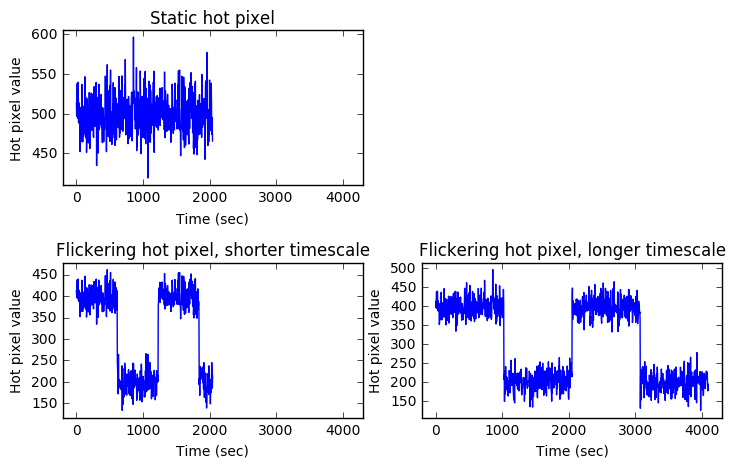

In [6]:
fig = plt.figure(figsize=(8.5, 5))

plt.subplot(2, 2, 1)
plt.plot(np.arange(nframes_500) * delta_t, static_hot_pixel_500.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Static hot pixel")
plt.xlim(-200, 4300)
plt.margins(0.05)

plt.subplot(2, 2, 3)
plt.plot(np.arange(nframes_500) * delta_t, flickering_hot_pixel_500.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Flickering hot pixel, shorter timescale")
plt.xlim(-200, 4300)
plt.margins(0.05)

plt.subplot(2, 2, 4)
plt.plot(np.arange(nframes_1000) * delta_t, flickering_hot_pixel_1000.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Flickering hot pixel, longer timescale")
plt.xlim(-200, 4300)
plt.margins(0.05)

plt.subplots_adjust(hspace=0.5)

In [7]:
def do_computations(slot, img_size, hot_pixels=None, bgd_kwargs=None, \
                    nframes=1000, ndeque=1000, delta_t=4.1, integ=1.696, \
                    bgdavg=None, fwhm=1.8, mag=10.2, \
                    delta=-0.25,  ampl=8., period=1000., phase=0.):
    
    rows_all = []

    for mag in mags:
    
        sim_kwargs['mag'] = mag
    
        np.random.seed(42)
        slot_data, true_centroids = siml0.simulate_aca_l0(img_size, hot_pixels=hot_pixels, **sim_kwargs)
    
        for i, Bgd_Class in enumerate([FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
            bgd_object = Bgd_Class(**bgd_kwargs[i])
            rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
            for row in rows:
                row['mag'] = mag
                row['bgd_class_name'] = bgd_object.__class__.__name__
                row['true_row'] = true_centroids[0]
                row['true_col'] = true_centroids[1]
                y_pixels = true_centroids[0] + row['row0']
                z_pixels = true_centroids[1] + row['col0']
                true_yanzan = transform.pixels_to_yagzag(y_pixels, z_pixels)
                row['true_yan'] = true_yanzan[0]
                row['true_zan'] = true_yanzan[1]
                if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                    row['ndeque'] = bgd_kwargs[i]['ndeque']
                else:
                    row['ndeque'] = None

                rows_all.append(row)
        
    t = Table(rows_all)
    return t


def plot_resids(table):
    faint = table['mag'] == 10.2
    bright = table['mag'] == 8.2

    key = 'yan'

    fig = plt.figure(figsize=(7.5, 2.5))

    methods = ['FlightBgd', 'DynamBgd_Median', 'DynamBgd_SigmaClip']

    for i, method in enumerate(methods):
        if i==0:
            ax1 = plt.subplot(1, 3, 1)
            plt.ylabel('delta {} (arcsec)'.format(key))
        else:
            ax = plt.subplot(1, 3, i + 1, sharey=ax1)
            plt.setp(ax.get_yticklabels(), visible=False)
        d_ang = table[bright][key][i] - table[faint][key][i]
        plt.plot(table['time'][0], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.title(method)    
        plt.xlabel('Time (sec)')
        plt.legend()
        plt.margins(0.05)
    
    plt.subplots_adjust(left=0.05, right=0.99, bottom=0.2, top=0.9,
                        hspace=0.3, wspace=0.1)
    print("Bright - Faint star, ndeque = {}".format(table[1]['ndeque']))
    return

In [8]:
img_size = 8 # pixels
integ = 1.696 # sec

In [9]:
# Define dither parameters
ampl, period = siml0.dither_acis()
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
phase = [phase_yaw, phase_pitch] # in 2 * np.pi
delta = 0.25 # px

In [10]:
# Average background
bgdavg = 10. # pixel value

In [11]:
slot = 0
mags = [10.2, 8.2] # mag

### Example: Simulation with 1 static hot pixel###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __one static hot pixel__, using all three background recipies <code>(FlightBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code> 

__Define hot pixel__

In [12]:
hot_pixels = {(6, 6):static_hot_pixel_500.hp}

__Small__ number of stored pixel values

In [13]:
ndeque = 5 # number of stored pixel values

In [14]:
# Keyword arguments to simulate aca_l0 data
sim_kwargs = {'nframes':nframes_500, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg,
              'ampl':ampl, 'period':period, 'phase':phase, 'delta':delta}

In [15]:
# Keyword arguments to initialize background objects
bgd_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                  {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

In [16]:
t_shp_5 = do_computations(slot, img_size, hot_pixels=hot_pixels, bgd_kwargs=bgd_kwargs, **sim_kwargs)

In [17]:
print(t_shp_5.colnames)

['bgd_class_name', 'bgdimg', 'col', 'col0', 'deque_dict', 'img', 'imgraw', 'mag', 'ndeque', 'row', 'row0', 'slot', 'time', 'true_col', 'true_row', 'true_yan', 'true_zan', 'yan', 'zan']


In [18]:
print(t_shp_5['bgd_class_name', 'mag', 'ndeque'])

  bgd_class_name   mag  ndeque
------------------ ---- ------
         FlightBgd 10.2   None
   DynamBgd_Median 10.2      5
DynamBgd_SigmaClip 10.2      5
         FlightBgd  8.2   None
   DynamBgd_Median  8.2      5
DynamBgd_SigmaClip  8.2      5


__Large__ number of stored pixel values

In [19]:
ndeque = 1000 # number of stored pixel values
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [20]:
t_shp_1000 = do_computations(slot, img_size, hot_pixels=hot_pixels, bgd_kwargs=bgd_kwargs, **sim_kwargs)

__Plot sequence of simulated star images and derived bgd images__

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither.
* <span style="color:crimson;font-weight:bold">8x8 patch</span> - 8x8 pixel region corresponding to background derived for a current frame (sampled edge pixels + average background value for pixels inside the edge).
* Notice <span style="color:yellowgreen;font-weight:bold">hot pixel</span> in the center of the black patch.

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 0 to 7
Bgd Class: DynamBgd_Median, ndeque = 5


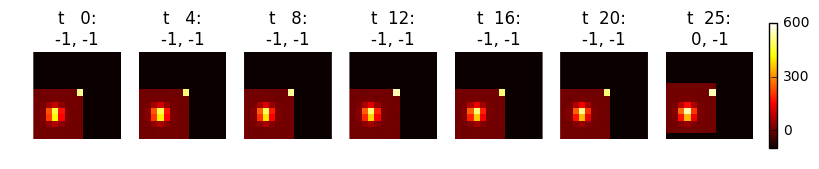

In [21]:
data = mplt.plot_images(t_shp_5, n_start=0, n_stop=7, slot=0, mag=mags[0],
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, colname='imgraw')

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 0 to 7
Bgd Class: DynamBgd_Median, ndeque = 5


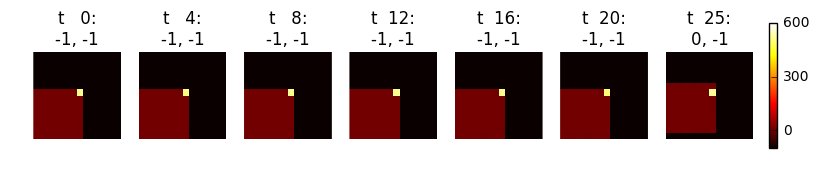

In [22]:
data = mplt.plot_images(t_shp_5, n_start=0, n_stop=7, slot=0, mag=mags[0],
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, colname='bgdimg')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 0 to 7
Bgd Class: DynamBgd_Median, ndeque = 5


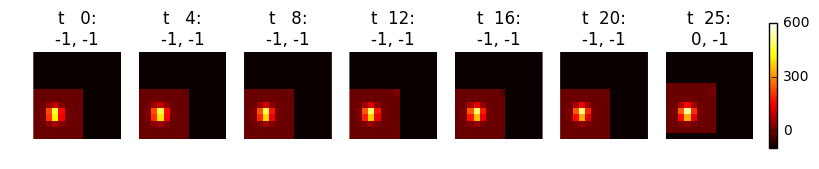

In [23]:
data = mplt.plot_images(t_shp_5, n_start=0, n_stop=7, slot=0, mag=mags[0],
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, colname='img')

__Plot sampled background pixels__

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither.
* <span style="color:crimson;font-weight:bold">Red patch</span> - pixels that were among the edge pixels (i.e. were sampled) at least once until 'now'.
* Notice <span style="color:yellowgreen;font-weight:bold">hot pixel</span> in the center of the black patch.

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 0 to 7
Bgd Class: DynamBgd_Median, ndeque = 5


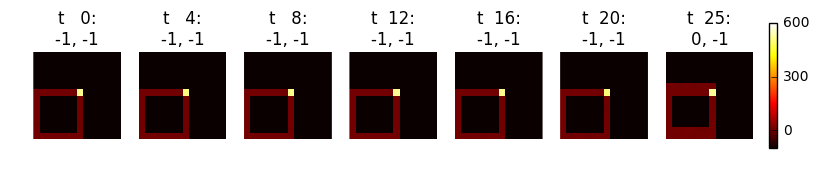

In [24]:
data = mplt.plot_bgd_patches(t_shp_5, n_start=0, n_stop=7, slot=0, mag=mags[0],
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-100)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 200 to 207
Bgd Class: DynamBgd_Median, ndeque = 5


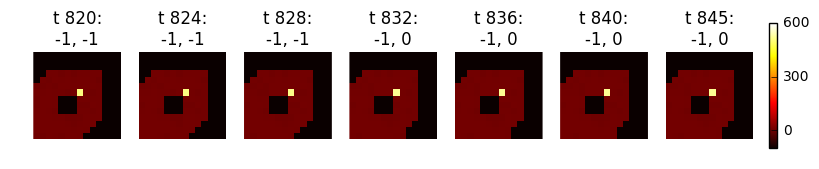

In [25]:
data = mplt.plot_bgd_patches(t_shp_5, n_start=200, n_stop=207, slot=0, mag=mags[0],
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-100)

__Plot the computed and 'true' centroids (yan coordinates)__

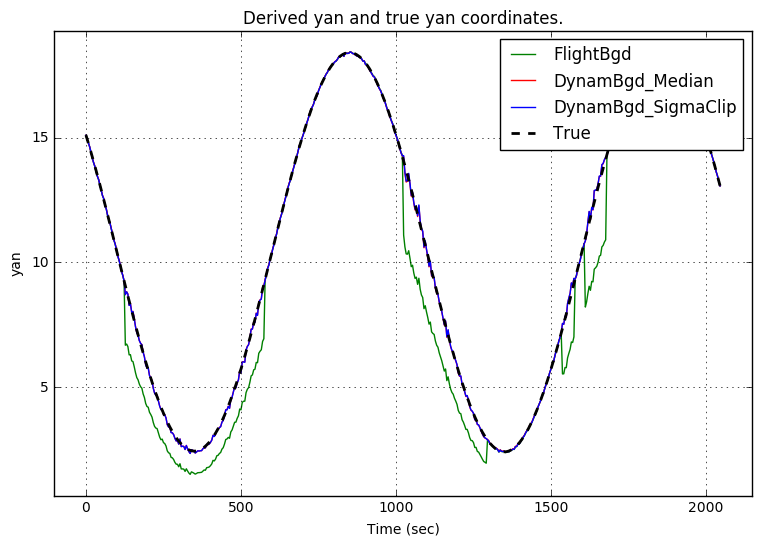

In [26]:
#Faint star
#mplt.plot_coords(slot, t_shp_5, 'row', mag=10.2) # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_shp_5, 'yan', mag=10.2) # computed 'yan' coordinate

__Plot difference between the computed and 'true' coordinates__

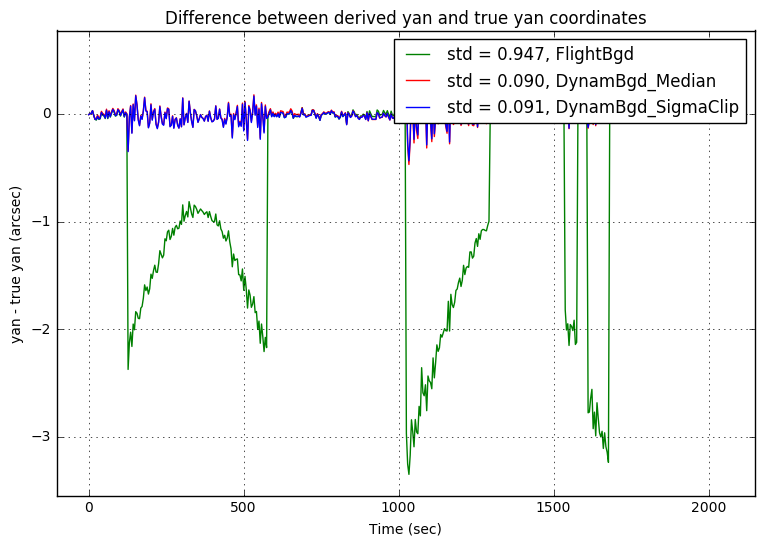

In [27]:
#mplt.plot_coords_excess(slot, t_shp_5, 'row')
mplt.plot_coords_excess(0, t_shp_5, 'yan')

__Plot residuals__

Static hot pixel
Bright - Faint star, ndeque = 5


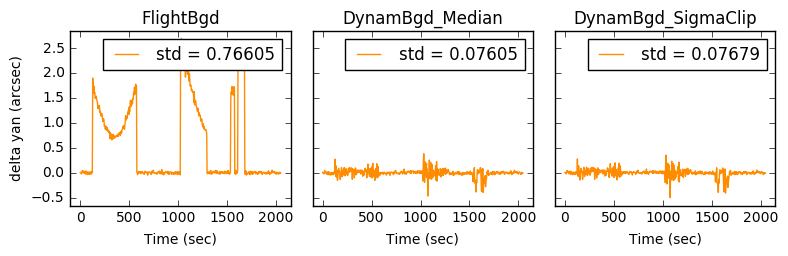

In [28]:
print("Static hot pixel")
plot_resids(t_shp_5)

Static hot pixel
Bright - Faint star, ndeque = 1000


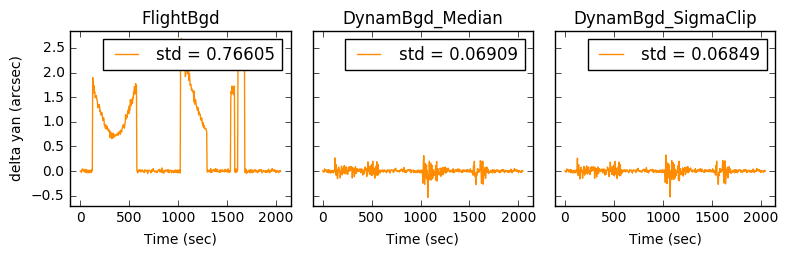

In [29]:
print("Static hot pixel")
plot_resids(t_shp_1000)

__Plot time history of the hot pixel.__ Compare with a 'cold' pixel.

* <span style="color:gray;font-weight:bold">Simulated</span> - simulated time series for the hot pixel
* <span style="color:slateblue;font-weight:bold">Sampled</span> - sampled values of the hot pixel at times when it ended on the edge of 8x8 image (time periods corresponding to horizontal lines means that the hot pixel was either among the [1:7, 1:7] part of the image, or outside of the 8x8 image.
* <span style="color:darkorange;font-weight:bold">Derived</span> - pixel value inferred using given background algorithm.

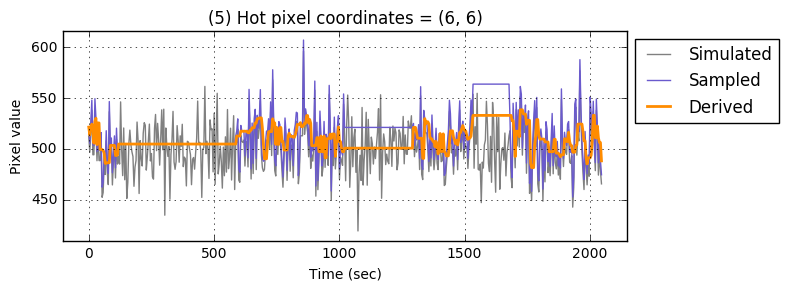

In [30]:
mplt.plot_px_history(t_shp_5, [(6, 6)], hot_pixels, slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_Median',
                     legend_text='Simulated', title_text='(5) Hot')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

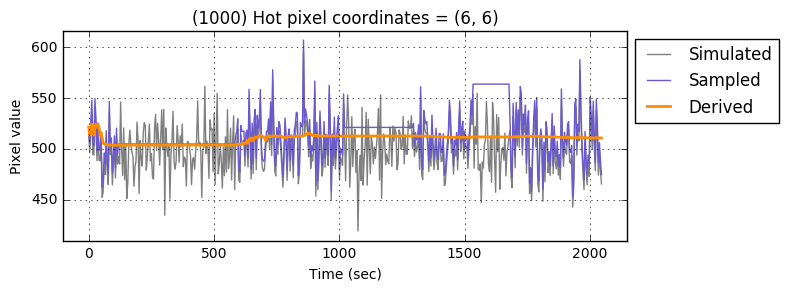

In [31]:
mplt.plot_px_history(t_shp_1000, [(6, 6)], hot_pixels, slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_Median',
                     legend_text='Simulated', title_text='(1000) Hot')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

__Plot a 'cold' pixel__ for validation

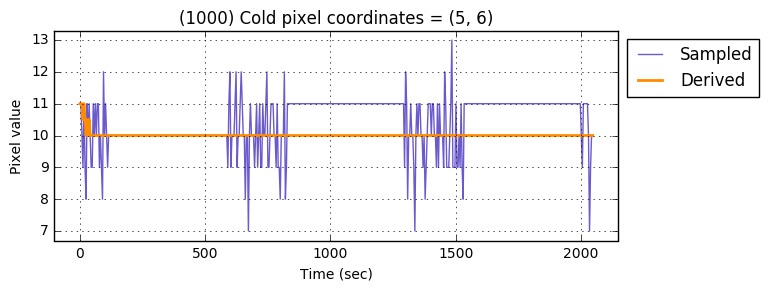

In [32]:
mplt.plot_px_history(t_shp_1000, [(5, 6)], slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_Median',
                    title_text='(1000) Cold')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

### Example: Simulation with 1 flickering hot pixel, shorter flickering timescale###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __one flickering hot pixel__, using all three background recipies <code>(FlightBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code> 

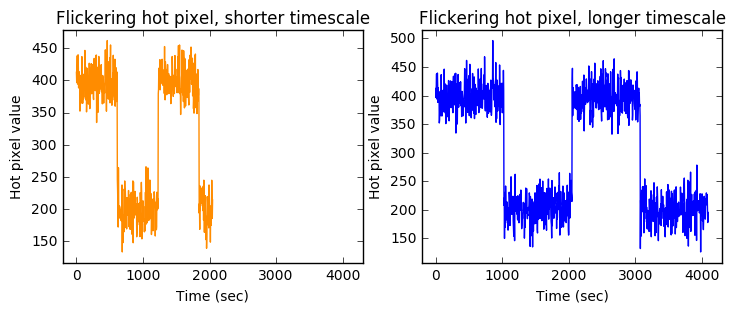

In [33]:
fig = plt.figure(figsize=(8.5, 3))

plt.subplot(1, 2, 1)
plt.plot(np.arange(nframes_500) * delta_t, flickering_hot_pixel_500.hp,
         color='DarkOrange')
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Flickering hot pixel, shorter timescale")
plt.xlim(-200, 4300)
plt.margins(0.05)

plt.subplot(1, 2, 2)
plt.plot(np.arange(nframes_1000) * delta_t, flickering_hot_pixel_1000.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Flickering hot pixel, longer timescale")
plt.xlim(-200, 4300)
plt.margins(0.05)

In [34]:
hot_pixels = {(6, 6):flickering_hot_pixel_500.hp}

__Small__ number of stored pixel values

In [35]:
ndeque = 5 # number of stored pixel values
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [36]:
t_fhp_5_500 = do_computations(slot, img_size, hot_pixels=hot_pixels,
                              bgd_kwargs=bgd_kwargs, **sim_kwargs)

__Large__ number of stored pixel values

In [37]:
ndeque = 1000 # number of stored pixel values
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [38]:
t_fhp_1000_500 = do_computations(slot, img_size, hot_pixels=hot_pixels,
                                  bgd_kwargs=bgd_kwargs, **sim_kwargs)

__Plots__

Flickering hot pixel
Bright - Faint star, ndeque = 5


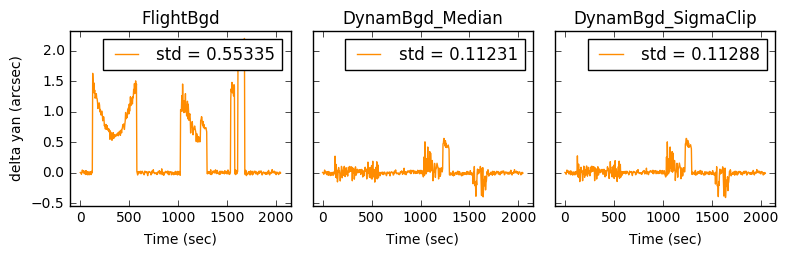

In [39]:
print("Flickering hot pixel")
plot_resids(t_fhp_5_500)

Flickering hot pixel
Bright - Faint star, ndeque = 1000


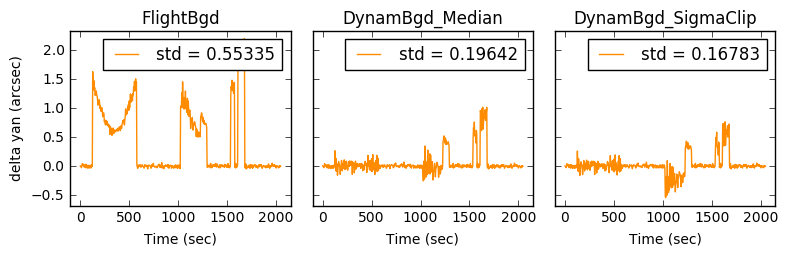

In [40]:
print("Flickering hot pixel")
plot_resids(t_fhp_1000_500)

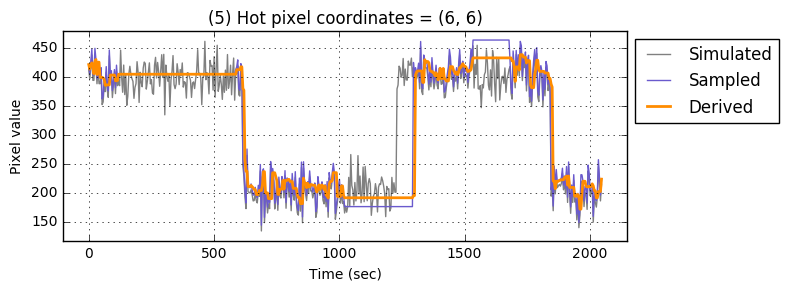

In [41]:
mplt.plot_px_history(t_fhp_5_500, [(6, 6)], hot_pixels, slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_Median',
                     legend_text='Simulated', title_text='(5) Hot')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

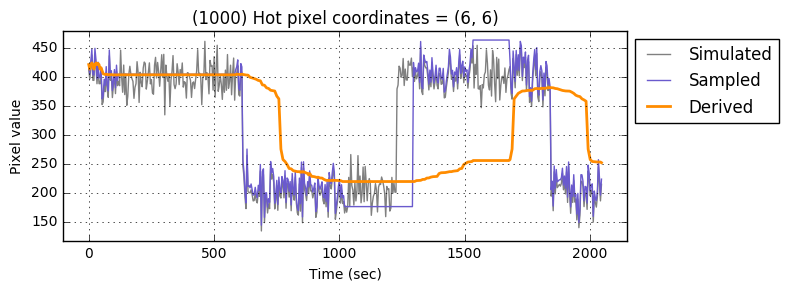

In [42]:
mplt.plot_px_history(t_fhp_1000_500, [(6, 6)], hot_pixels, slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_Median',
                     legend_text='Simulated', title_text='(1000) Hot')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

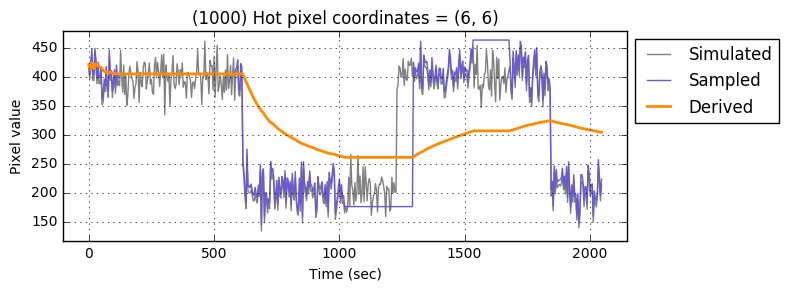

In [43]:
mplt.plot_px_history(t_fhp_1000_500, [(6, 6)], hot_pixels, slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_SigmaClip',
                     legend_text='Simulated', title_text='(1000) Hot')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 290 to 311
Bgd Class: DynamBgd_Median, ndeque = 1000


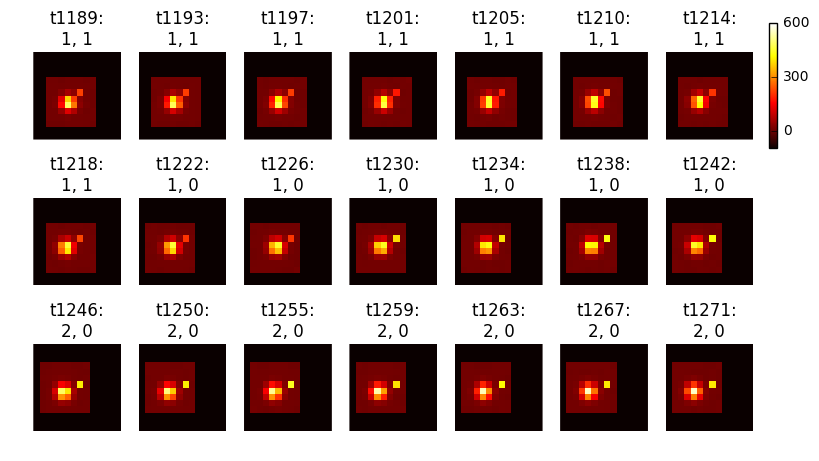

In [44]:
data = mplt.plot_images(t_fhp_1000_500, n_start=290, n_stop=311, slot=0, mag=mags[0],
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-100, colname='imgraw')

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 290 to 311
Bgd Class: DynamBgd_Median, ndeque = 1000


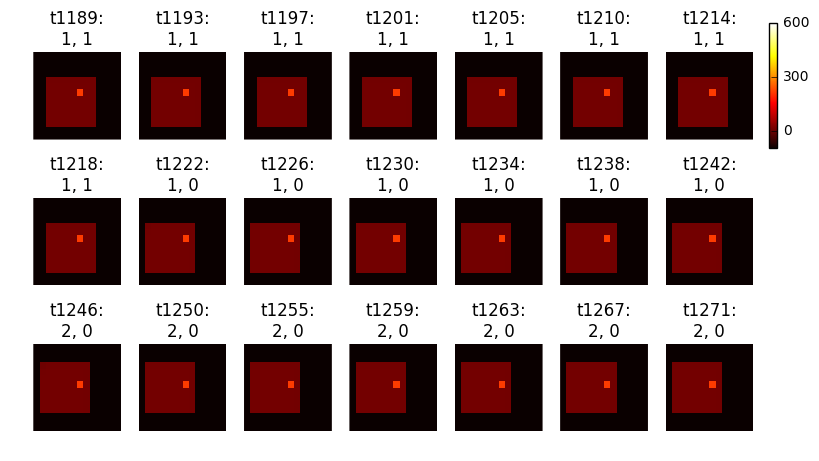

In [45]:
data = mplt.plot_images(t_fhp_1000_500, n_start=290, n_stop=311, slot=0, mag=mags[0],
                            img_size=img_size, bgd_class_name='DynamBgd_Median',
                            vmin=-100, colname='bgdimg')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 290 to 311
Bgd Class: DynamBgd_Median, ndeque = 1000


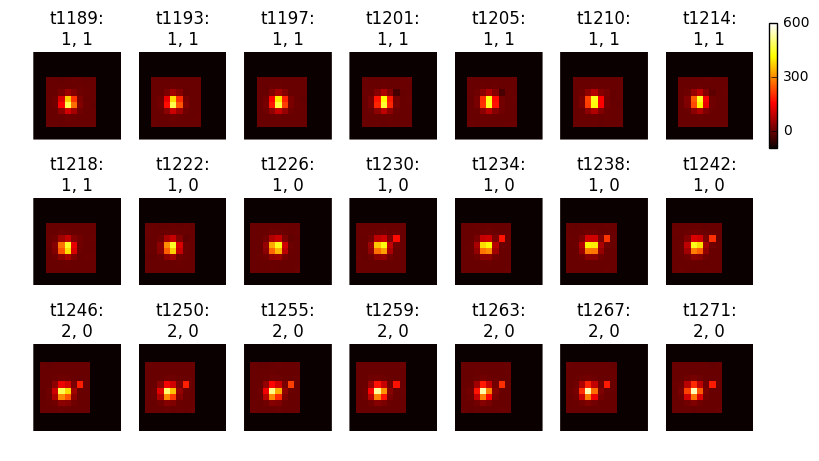

In [46]:
data = mplt.plot_images(t_fhp_1000_500, n_start=290, n_stop=311, slot=0, mag=mags[0],
                            img_size=img_size, bgd_class_name='DynamBgd_Median',
                            vmin=-100, colname='img')

### Example: Simulation with 1 flickering hot pixel, longer flickering timescale###

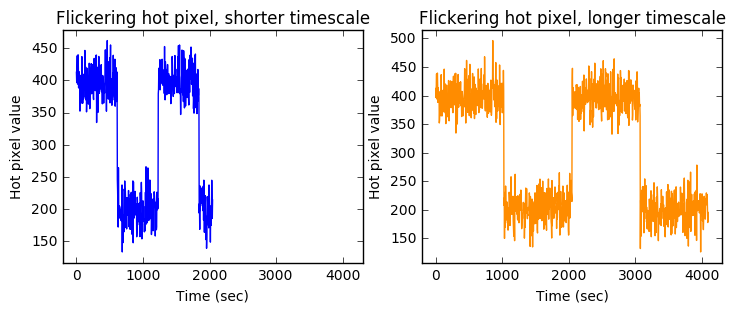

In [47]:
fig = plt.figure(figsize=(8.5, 3))

plt.subplot(1, 2, 1)
plt.plot(np.arange(nframes_500) * delta_t, flickering_hot_pixel_500.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Flickering hot pixel, shorter timescale")
plt.xlim(-200, 4300)
plt.margins(0.05)

plt.subplot(1, 2, 2)
plt.plot(np.arange(nframes_1000) * delta_t, flickering_hot_pixel_1000.hp,
         color='DarkOrange')
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.title("Flickering hot pixel, longer timescale")
plt.xlim(-200, 4300)
plt.margins(0.05)

In [48]:
hot_pixels = {(6, 6):flickering_hot_pixel_1000.hp}

__Large__ number of samples

In [49]:
sim_kwargs['nframes'] = nframes_1000

In [50]:
ndeque = 25 # number of stored pixel values
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [51]:
t_fhp_25_1000 = do_computations(slot, img_size, hot_pixels=hot_pixels,
                                bgd_kwargs=bgd_kwargs, **sim_kwargs)

Flickering hot pixel
Bright - Faint star, ndeque = 25


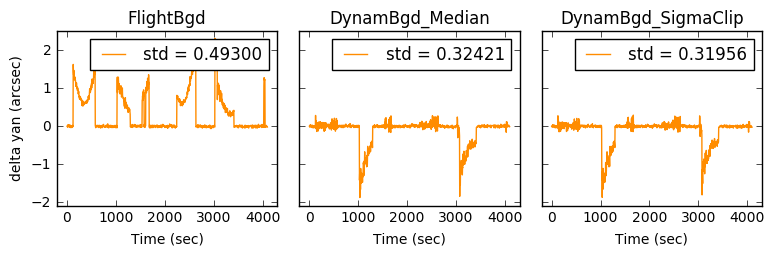

In [52]:
print("Flickering hot pixel")
plot_resids(t_fhp_25_1000)

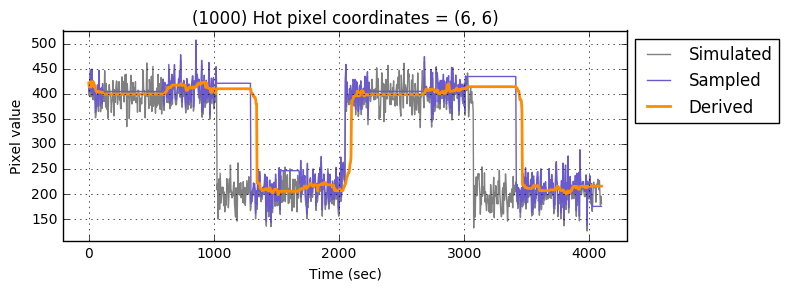

In [53]:
mplt.plot_px_history(t_fhp_25_1000, [(6, 6)], hot_pixels, slot=0, mag=10.2,
                     bgd_class_name='DynamBgd_Median',
                     legend_text='Simulated', title_text='(1000) Hot')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));